

# Markdown company take-home challenge...identify 'adopted' users





identify 'adopted' users from user factors and login information

1. load data
2. clean data
3. calculate 'label'
4. plot data
5. generate hypothesis  / viz
6. expand features
    * temporal information
7. generate model (e.g., RF, xgBoost)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import numpy as np

from sklearn.metrics import f1_score


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix


In [2]:

import datetime
print(
    datetime.datetime.utcfromtimestamp(
        int("1398138810")
    ).strftime('%Y-%m-%d %H:%M:%S')
)

print(
    datetime.datetime.fromtimestamp(
        int("1398138810")
    ).strftime('%Y-%m-%d %H:%M:%S')
)


2014-04-22 03:53:30
2014-04-21 23:53:30


In [3]:
import os

#path = 'C:\\Users\\rozoe\OneDrive\\jy\\RelaxChallengUnit17p2\\'
path = '.\\'
path

os.listdir(path)

['.ipynb_checkpoints',
 '1481069814_relax_challenge',
 '1481069814_relax_challenge.zip',
 'RelaxChallenge-Copy1.ipynb',
 'RelaxChallenge-Copy2.ipynb',
 'RelaxChallenge-Copy3.ipynb',
 'RelaxChallenge.ipynb',
 'relaxSpyder - Copy.py',
 'relaxSpyder.py',
 'relaxWork-Copy1.ipynb',
 'relaxWork-Copy2.ipynb',
 'relaxWork-Copy3.ipynb',
 'relaxWork-Copy4.ipynb',
 'relaxWork.ipynb',
 'relax_data_science_challenge.pdf',
 'Sample',
 'takehome_users.csv',
 'takehome_user_engagement.csv']

# Process Logon Information

1. read data
2. clean data : 
timestamp conversion; 
date conversion
3. rolling signon window 

In [4]:
flogin = path + 'takehome_user_engagement.csv'
flogin

parse_dates = ['time_stamp']
# logins = pd.read_csv('takehome_user_engagement.csv',parse_dates=parse_dates)
logins = pd.read_csv(flogin,parse_dates=parse_dates)
logins.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [5]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [6]:
logins.visited.value_counts()

1    207917
Name: visited, dtype: int64

In [7]:
worklogins = logins.copy(deep=True)
worklogins['date'] = pd.to_datetime(worklogins.time_stamp.dt.date)
worklogins.drop('time_stamp', axis=1, inplace=True)

worklogins.head()

,user_id,visited,date
0,1,1,2014-04-22
1,2,1,2013-11-15
2,2,1,2013-11-29
3,2,1,2013-12-09
4,2,1,2013-12-25


In [8]:
# verify no duplicate dates
nodup_check = len(worklogins.groupby(['user_id', 'date']).visited.count().sort_values(ascending=False)) == len(worklogins)
print(nodup_check)
## just in case
worklogins.drop_duplicates(inplace=True)

worklogins.sort_values(['user_id', 'date'], inplace=True)
print(worklogins.head(), '\n', worklogins.tail())

True
   user_id  visited       date
0        1        1 2014-04-22
1        2        1 2013-11-15
2        2        1 2013-11-29
3        2        1 2013-12-09
4        2        1 2013-12-25 
         user_id  visited       date
207912    11996        1 2013-09-06
207913    11997        1 2013-01-15
207914    11998        1 2014-04-27
207915    11999        1 2012-06-02
207916    12000        1 2014-01-26


In [9]:
# get # days difference between 3 consecutive logins

worklogins['diff'] = worklogins.groupby('user_id')['date'].apply(lambda x: x - x.shift(+2)  ) / np.timedelta64(1, 'D')
print(worklogins.head(), '\n', worklogins.tail(15))


   user_id  visited       date  diff
0        1        1 2014-04-22   NaN
1        2        1 2013-11-15   NaN
2        2        1 2013-11-29   NaN
3        2        1 2013-12-09  24.0
4        2        1 2013-12-25  26.0 
         user_id  visited       date  diff
207902    11988        1 2014-06-01   6.0
207903    11989        1 2013-09-07   NaN
207904    11990        1 2013-07-06   NaN
207905    11991        1 2014-04-20   NaN
207906    11991        1 2014-04-25   NaN
207907    11991        1 2014-04-28   8.0
207908    11991        1 2014-05-17  22.0
207909    11991        1 2014-05-30  32.0
207910    11992        1 2014-04-11   NaN
207911    11995        1 2013-10-22   NaN
207912    11996        1 2013-09-06   NaN
207913    11997        1 2013-01-15   NaN
207914    11998        1 2014-04-27   NaN
207915    11999        1 2012-06-02   NaN
207916    12000        1 2014-01-26   NaN


In [10]:
# Extract users having 3 logins within 7 days
tempUsers = worklogins[worklogins['diff'] <= 7]
tempUsers

# get unique user_id's and label them with a '1'

adopted = pd.DataFrame(tempUsers.user_id.unique(),columns=['user_id'])
adopted['label'] = 1
print(adopted.head())
print(adopted.tail())


   user_id  label
0        2      1
1       10      1
2       20      1
3       33      1
4       42      1
      user_id  label
1651    11965      1
1652    11967      1
1653    11969      1
1654    11975      1
1655    11988      1


# Process User file

In [11]:
fusers = path + 'takehome_users.csv'
parse_user_dates = ['creation_time']
users = pd.read_csv(fusers, encoding = "ISO-8859-1", parse_dates=parse_user_dates)
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [12]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   float64       
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 937.6+ KB


In [13]:
users.describe()

,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
count,12000.00000,8.823000e+03,12000.000000,12000.000000,12000.000000,6417.000000
mean,6000.50000,1.379279e+09,0.249500,0.149333,141.884583,5962.957145
std,3464.24595,1.953116e+07,0.432742,0.356432,124.056723,3383.761968
min,1.00000,1.338452e+09,0.000000,0.000000,0.000000,3.000000
25%,3000.75000,1.363195e+09,0.000000,0.000000,29.000000,3058.000000
50%,6000.50000,1.382888e+09,0.000000,0.000000,108.000000,5954.000000
75%,9000.25000,1.398443e+09,0.000000,0.000000,238.250000,8817.000000
max,12000.00000,1.402067e+09,1.000000,1.000000,416.000000,11999.000000


## clean up users data

In [14]:
df = users.copy(deep=True)

In [15]:
# determine what to set null invited_by_user_id to 
users.invited_by_user_id.min(), users.object_id.min()

(3.0, 1)

In [16]:
# Fill NA
df.invited_by_user_id.fillna(0,inplace=True)
df.last_session_creation_time.fillna(0, inplace=True)


In [17]:
# get datetime from timestamp
df['last_session_dt'] = df.apply(lambda x: datetime.datetime.utcfromtimestamp(x['last_session_creation_time']),axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  12000 non-null  float64       
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          12000 non-null  float64       
 10  last_session_dt             12000 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(4), object(3)


# email and temporal data do not translate to future data...therefore extract features from them: 

* email_domain
* active_duration

In [18]:

# Generate Feature columns: active_duration & email_domain

df['email_domain'] = df.email.str.extract(r'@(.+)$', expand=True)
df

emailtemp = pd.DataFrame(df.email_domain.value_counts()).reset_index()
emailtemp.columns =['email_domain','value']
emailtemp

# there are only a handful  of common ones...create cats only for those
emailtemp = emailtemp[emailtemp.value > 2]
emailtemp['top_domains'] = emailtemp.email_domain
emailtemp

,email_domain,value,top_domains
0,gmail.com,3562,gmail.com
1,yahoo.com,2447,yahoo.com
2,jourrapide.com,1259,jourrapide.com
3,cuvox.de,1202,cuvox.de
4,gustr.com,1179,gustr.com
5,hotmail.com,1165,hotmail.com


In [19]:
# update df / user table with top ones...
df = pd.merge(df, emailtemp, how='left')
df.top_domains.fillna('other', inplace=True)
df[['email', 'top_domains']].tail(11)

,email,top_domains
11989,AasePJuhl@jourrapide.com,jourrapide.com
11990,ArthurJVaughn@gmail.com,gmail.com
11991,AmandaAHermansen@yahoo.com,yahoo.com
11992,IsabelTownsend@cuvox.de,cuvox.de
11993,conxzghp@eaouk.com,other
11994,SebastianWerfel@gmail.com,gmail.com
11995,SophiaMeier@gustr.com,gustr.com
11996,AmelieFisher@gmail.com,gmail.com
11997,JakeHaynes@cuvox.de,cuvox.de
11998,mhaerzxp@iuxiw.com,other


In [20]:
# Generate active duration feature

df['active_duration'] = (df.last_session_dt - df.creation_time).dt.days

# make fix for users that never created a session (it was initited to default base time)
df['active_duration'][df.last_session_creation_time == 0] = 0 

df[['creation_time','last_session_dt', 'active_duration' ]].head()

C:\Users\rozoe\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,creation_time,last_session_dt,active_duration
0,2014-04-22 03:53:30,2014-04-22 03:53:30,0
1,2013-11-15 03:45:04,2014-03-31 03:45:04,136
2,2013-03-19 23:14:52,2013-03-19 23:14:52,0
3,2013-05-21 08:09:28,2013-05-22 08:09:28,1
4,2013-01-17 10:14:20,2013-01-22 10:14:20,5


# Merge user and label (sign in) data 

In [21]:
data = pd.merge(df, adopted, left_on=['object_id'], right_on=['user_id'], how='left')
data.label.fillna(0, inplace=True)
data.drop('user_id', axis=1, inplace=True)
data
list(data.columns)

 

['object_id',
 'creation_time',
 'name',
 'email',
 'creation_source',
 'last_session_creation_time',
 'opted_in_to_mailing_list',
 'enabled_for_marketing_drip',
 'org_id',
 'invited_by_user_id',
 'last_session_dt',
 'email_domain',
 'value',
 'top_domains',
 'active_duration',
 'label']

In [22]:
# choose features to consider and create df

feature_columns = [ 
 
    'creation_source',
 
    'opted_in_to_mailing_list',
    'enabled_for_marketing_drip',
    'org_id',
    'invited_by_user_id',
 
 
 
    'top_domains',
    'active_duration',
    'label']

df_features = data[feature_columns]

df_features.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,top_domains,active_duration,label
0,GUEST_INVITE,1,0,11,10803.0,yahoo.com,0,0.0
1,ORG_INVITE,0,0,1,316.0,gustr.com,136,1.0
2,ORG_INVITE,0,0,94,1525.0,gustr.com,0,0.0
3,GUEST_INVITE,0,0,1,5151.0,yahoo.com,1,0.0
4,GUEST_INVITE,0,0,193,5240.0,yahoo.com,5,0.0



# Plot data

C:\Users\rozoe\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\rozoe\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\rozoe\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


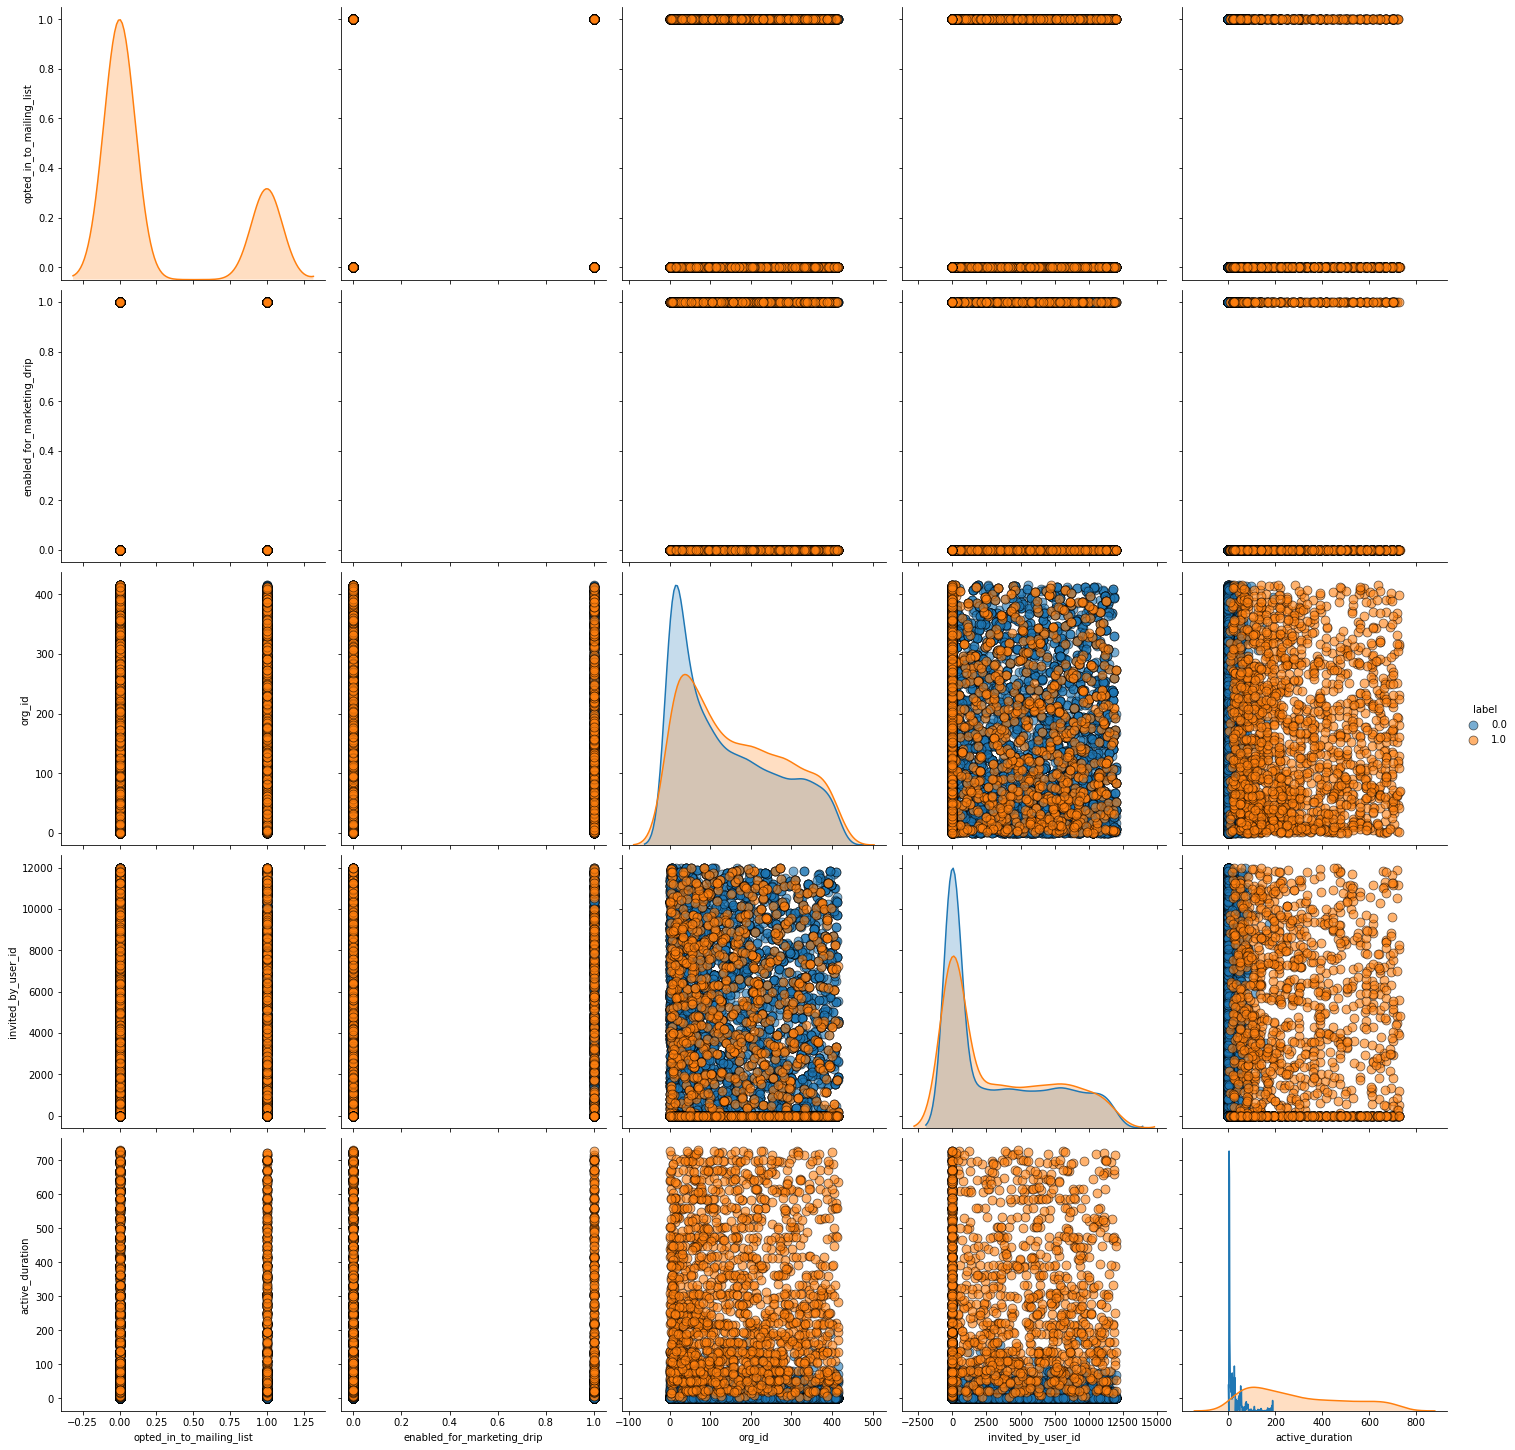

In [23]:
sns.pairplot(df_features, hue='label', diag_kind = 'kde',
             plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'},
             height = 4)


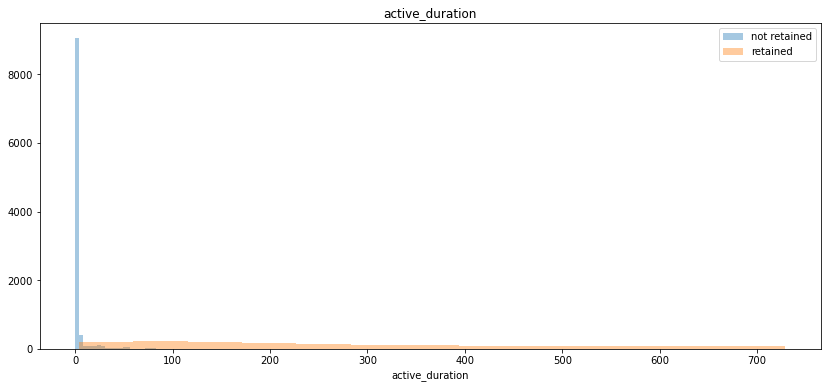

In [24]:
# active range details: hist plot
fig = plt.figure(figsize=(14,6))
ax = sns.distplot(df_features[df_features['label']==0].active_duration, label='not retained', kde=False)
sns.distplot(df_features[df_features['label']==1].active_duration , label='retained', kde=False)
ax.set_title('active_duration')
plt.legend()

# Create Model

In [25]:
# process categorical columns

dummy_columns = ['creation_source','top_domains']
#dummy_columns = ['creation_source']
df_with_dummies = pd.get_dummies( df_features, columns = dummy_columns)

# df_with_dummies.drop('last_session_creation_time')

df_with_dummies.head()


,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,active_duration,label,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,top_domains_cuvox.de,top_domains_gmail.com,top_domains_gustr.com,top_domains_hotmail.com,top_domains_jourrapide.com,top_domains_other,top_domains_yahoo.com
0,1,0,11,10803.0,0,0.0,1,0,0,0,0,0,0,0,0,0,0,1
1,0,0,1,316.0,136,1.0,0,1,0,0,0,0,0,1,0,0,0,0
2,0,0,94,1525.0,0,0.0,0,1,0,0,0,0,0,1,0,0,0,0
3,0,0,1,5151.0,1,0.0,1,0,0,0,0,0,0,0,0,0,0,1
4,0,0,193,5240.0,5,0.0,1,0,0,0,0,0,0,0,0,0,0,1


In [26]:
y = df_with_dummies.label 
X = df_with_dummies.drop('label', axis=1)
np.random.seed(seed = 42)
 
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size = 0.7, random_state = 42)



from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 42)

In [27]:
# Cross Validation to verify no  anomolies in training data
#https://medium.com/@hjhuney/implementing-a-random-forest-classification-model-in-python-583891c99652

#rfc_cv_score = cross_val_score(rfc, X, y, cv=10, scoring=’roc_auc’) # bad tick marks from copy
rf_cv_score = cross_val_score(rf, X_train, y_train, cv=5, scoring='roc_auc')

rf_cv_score

array([0.99149286, 0.99236524, 0.98816022, 0.9873476 , 0.98905   ])

In [28]:
# fit model using all training data and make predictions
rf.fit(X_train, y_train)
rf_predict = rf.predict(X_valid)

In [29]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_valid, rf_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_valid, rf_predict))
print('\n')
print("=== All AUC Scores ===")
print(rf)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rf_cv_score.mean())

=== Confusion Matrix ===
[[3072   28]
 [  60  440]]


=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      3100
         1.0       0.94      0.88      0.91       500

    accuracy                           0.98      3600
   macro avg       0.96      0.94      0.95      3600
weighted avg       0.98      0.98      0.98      3600



=== All AUC Scores ===
RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=42)


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.9896831827012498


In [30]:

# calculate f1_score
y_pred = rf.predict(X_valid)
rf_f1 = f1_score(y_valid, y_pred)
rf_f1


0.909090909090909

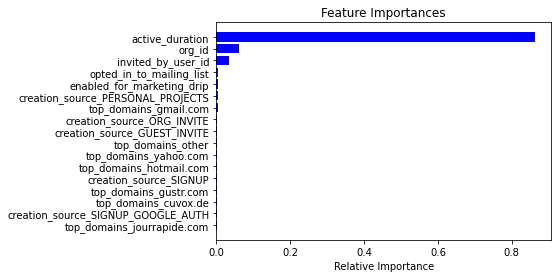

In [31]:

# plot feature importance

features = X.columns
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


In [32]:
# display table of feature importance values
fi = pd.DataFrame(importances, index=X.columns, columns =['importance']).sort_values('importance', ascending=False)
fi

,importance
active_duration,0.863507
org_id,0.060606
invited_by_user_id,0.033166
opted_in_to_mailing_list,0.005036
enabled_for_marketing_drip,0.004700
creation_source_PERSONAL_PROJECTS,0.003715
top_domains_gmail.com,0.003394
creation_source_ORG_INVITE,0.003159
creation_source_GUEST_INVITE,0.002882
top_domains_other,0.002844


# SUMMARY: 
## Of the features considered the following are predictor candidates:

* active_duration is a highly significant feature
* org_id and invited_by_user_id are slightly significant

* the subscription factors  (opted_in_to_mailing_list, enabled_for_marketing_drip)  are not that significant, but slightly more so than the remaining features
